In [1]:
from collections import defaultdict
from functools import lru_cache
from pathlib import Path

import aquarel
import ir_datasets
import ir_measures
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyterrier as pt
from ir_datasets import docs_parent_id
from tqdm import tqdm

import sys

if ".." not in sys.path:
    sys.path.append("..")

from set_encoder.data import register_rank_distillm_novelty

register_rank_distillm_novelty()

DASHED_DATASET_MAP = {
    dataset.replace("/", "-"): dataset for dataset in ir_datasets.registry._registered
}

def get_parent(dataset_id):
    parent_id = docs_parent_id(dataset_id)
    if "medline" in parent_id:
        return parent_id.replace("/2004", "").replace("/2017", "")
    return parent_id 

In [2]:
theme = aquarel.Theme.from_file("./aquarel-theme.json")
theme.apply()
markers = ["o", "X", "s", "v", "P", "*", "D"]
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

## Helper Functions

In [3]:
@lru_cache(maxsize=2_048)
def load_run(run_file):
    run = pd.read_csv(
        run_file,
        sep=r"\s+",
        header=None,
        names=["query_id", "Q0", "doc_id", "rank", "score", "run_name"],
    )
    run = run.sort_values(["query_id", "score"], ascending=[True, False])
    run["rank"] = run.groupby("query_id")["score"].rank(ascending=False, method="first")

    run_name = run_file.parent.name

    if "chatnoir" in run_name or "colbert" in run_name or "bm25" in run_name:
        if "colbert" in run_name:
            first_stage = "colbert"
        else:
            first_stage = "bm25"
        run_name = "first_stage"
        dataset_name = run_file.name.split(".")[0]
    else:
        split = run_file.name.split(".")[0].split("_")
        if len(split) == 2:
            first_stage, dataset_name = split
        else:
            first_stage = "bm25"
            dataset_name = split[0]
        if "tirex" in first_stage:
            first_stage = "bm25"
    dataset_id = DASHED_DATASET_MAP[dataset_name]

    config = {}
    config["run_name"] = run_name
    config["dataset"] = dataset_id
    config["first_stage"] = first_stage

    run = run.astype({"query_id": str, "doc_id": str})
    return run, config


@lru_cache
def load_qrels(dataset):
    dataset = ir_datasets.load(dataset)
    qrels_df = pd.DataFrame(dataset.qrels_iter())
    return qrels_df


@lru_cache
def load_topics(dataset):
    dataset = ir_datasets.load(dataset)
    topics_df = pd.DataFrame(dataset.queries_iter())
    return topics_df

In [4]:
def evaluate_runs(
    per_dataset_runs, baseline, ir_measures_metrics, models, datasets, group_by_base=False, compute_means=False
):
    _results = []
    filtered_per_dataset_runs = defaultdict(dict)
    for dataset in datasets:
        for run_name, run in per_dataset_runs[dataset].items():
            if run_name in models:
                filtered_per_dataset_runs[dataset][run_name] = run
    pg = tqdm(datasets)
    topics = []
    qrels = []
    runs = defaultdict(list)
    for idx, (first_stage, dataset) in enumerate(pg):
        pg.set_description(f"{first_stage}-{dataset}")
        runs_dict = filtered_per_dataset_runs.get((first_stage, dataset))
        if runs_dict is None:
            raise ValueError(f"Run not found for {first_stage}-{dataset}")
        qrels.append(
            load_qrels(dataset).rename(
                columns={"query_id": "qid", "doc_id": "docno", "relevance": "label", "subtopic_id": "iteration"}
            )
        )
        topics.append(load_topics(dataset).rename(columns={"query_id": "qid"}))
        for run_name, run in runs_dict.items():
            runs[run_name].append(run.rename(columns={"query_id": "qid", "doc_id": "docno"}).astype({"docno": str}))

        base = get_parent(dataset)
        next_base = get_parent(datasets[idx + 1][1]) if idx + 1 < len(datasets) else None
        if not group_by_base or base != next_base:
            run_names = list(runs.keys())
            run_dfs = [pd.concat(runs[run_name]) for run_name in run_names]
            try:
                base_index = run_names.index(baseline)
                kwargs = {"baseline": base_index, "correction": "holm"}
            except ValueError:
                kwargs = {}

            # filter empty runs
            all_topics = pd.concat(topics)
            run_topics = [set(df["qid"].unique()) for df in run_dfs]
            topics_union = set.intersection(*run_topics)
            all_topics = all_topics.loc[all_topics["qid"].isin(topics_union)]
            all_qrels = pd.concat(qrels)
            all_qrels = all_qrels.loc[all_qrels["qid"].isin(topics_union)]
            run_dfs = [df.loc[df["qid"].isin(topics_union)].reset_index(drop=True) for df in run_dfs]

            result = pt.Experiment(run_dfs, all_topics, all_qrels, ir_measures_metrics, names=run_names, **kwargs)
            topics = []
            qrels = []
            runs = defaultdict(list)
            result["first_stage"] = first_stage
            if group_by_base:
                result["dataset"] = base
            else:
                result["dataset"] = dataset
            _results.append(result)

    results = pd.concat(_results)

    if compute_means:

        def gmean(x):
            return np.exp(np.log(x.prod()) / x.notna().sum())

        str_metrics = [str(m) for m in ir_measures_metrics]

        arithmetic_mean = results.groupby("name")[str_metrics].mean().reset_index()
        arithmetic_mean["dataset"] = "arithmetic-mean"
        geometric_mean = results.groupby("name")[str_metrics].agg(gmean).reset_index()
        geometric_mean["dataset"] = "geometric-mean"

        summary = pd.concat([arithmetic_mean, geometric_mean])
        results = pd.concat([results, summary])

    return results

In [5]:
def format_columns(series, round_to=3):
    drop_rows = ["cohere-embed-english-v3", "bge-base-en-v1"]
    rounded = series.round(round_to)
    values = sorted(set(rounded.drop(drop_rows, axis=0, errors="ignore").dropna()), reverse=True)
    best = values[0]
    second_best = values[1]
    out_values = []
    for val in rounded:
        if pd.isna(val):
            out_val = "--"
        else:
            out_val = f"{val:.{round_to}f}"
        if val == best:
            out_val = "\\textbf{" + out_val + "}"
        if val == second_best:
            out_val = "\\underline{" + out_val + "}"
        out_values.append(out_val)
    out = pd.Series(out_values, index=series.index)
    return out

## Load runs

In [6]:
EXPERIMENTS_DIR = Path.cwd().parent / "data" / "runs" / "experiments"

per_dataset_runs = defaultdict(dict)

run_files = list(EXPERIMENTS_DIR.glob("*/*.run"))

models = set()
datasets = set()
pg = tqdm(run_files)
for run_file in pg:
    pg.set_description(str(run_file.relative_to(EXPERIMENTS_DIR)))
    run, config = load_run(run_file)
    models.add(config["run_name"])
    datasets.add((config["first_stage"], config["dataset"]))
    per_dataset_runs[(config["first_stage"], config["dataset"])][config["run_name"]] = run

# filter top-100 from tirex runs since tirex re-ranked top 1000
pg = tqdm(per_dataset_runs)
for first_stage, dataset in pg:
    if first_stage != "bm25":
        continue
    pg.set_description(f"{first_stage}-{dataset}")
    runs = per_dataset_runs[(first_stage, dataset)]
    run_names = list(runs.keys())
    first_stage_run = runs["first_stage"]
    run_names.remove("first_stage")
    first_stage_top_100 = first_stage_run.loc[first_stage_run["rank"] <= 100]
    query_doc_id_pairs = first_stage_top_100.set_index(["query_id", "doc_id"]).index
    for run_name in run_names:
        run = runs[run_name]
        run = run.set_index(["query_id", "doc_id"])
        run = run.reindex(query_doc_id_pairs).dropna()
        run = run.reset_index()
        run["rank"] = run.groupby("query_id")["score"].rank(ascending=False, method="first")
        run = run.sort_values(["query_id", "rank"])
        per_dataset_runs[(first_stage, dataset)][run_name] = run
    

models, datasets

monoelectra-large/tirex-rerank_antique-test.run:   0%|          | 0/488 [00:00<?, ?it/s]                  

bm25-gov2/trec-tb-2005: 100%|██████████| 43/43 [00:06<00:00,  6.41it/s]                          


({'castorini-list-in-t5-300',
  'first_stage',
  'monoelectra-base',
  'monoelectra-base-naranknet',
  'monoelectra-large',
  'monot5-3b',
  'rankgpt-4',
  'rankgpt-4-turbo',
  'rankgpt-4o',
  'rankgpt-4o-full',
  'rankgpt-4o-full-novelty',
  'rankgpt-4o-novelty',
  'rankt5-3b',
  'rankzephyr',
  'rankzephyr-novelty',
  'set-encoder-base',
  'set-encoder-base-naranknet',
  'set-encoder-base-noduplicate',
  'set-encoder-base-noduplicate-naranknet',
  'set-encoder-base-noint',
  'set-encoder-large'},
 {('bm25', 'antique/test'),
  ('bm25', 'argsme/2020-04-01/touche-2020-task-1'),
  ('bm25', 'argsme/2020-04-01/touche-2021-task-1'),
  ('bm25', 'clueweb09/en/trec-web-2009'),
  ('bm25', 'clueweb09/en/trec-web-2010'),
  ('bm25', 'clueweb09/en/trec-web-2011'),
  ('bm25', 'clueweb09/en/trec-web-2012'),
  ('bm25', 'clueweb12/touche-2020-task-2'),
  ('bm25', 'clueweb12/touche-2021-task-2'),
  ('bm25', 'clueweb12/trec-web-2013'),
  ('bm25', 'clueweb12/trec-web-2014'),
  ('bm25', 'cord19/fulltext/tr

## Evaluate TREC DL

In [7]:
trec_dl_models = [
    "first_stage",
    "rankgpt-4o",
    "rankgpt-4o-full",
    "rankzephyr",
    "castorini-list-in-t5-300",
    "monot5-3b",
    "rankt5-3b",
    "monoelectra-base",
    "monoelectra-large",
    "set-encoder-base",
    "set-encoder-large",
]

trec_dl_datasets = [
    ("bm25", "msmarco-passage/trec-dl-2019/judged"),
    ("bm25", "msmarco-passage/trec-dl-2020/judged"),
    ("colbert", "msmarco-passage/trec-dl-2019/judged"),
    ("colbert", "msmarco-passage/trec-dl-2020/judged"),
]

trec_dl_results = evaluate_runs(
    per_dataset_runs,
    "set-encoder-large",
    [ir_measures.nDCG(cutoff=10)],
    trec_dl_models,
    trec_dl_datasets,
)

colbert-msmarco-passage/trec-dl-2020/judged: 100%|██████████| 4/4 [00:02<00:00,  1.79it/s]


In [8]:
index = "name"
columns = ["dataset", "first_stage"]
values = ["nDCG@10"]

pd.set_option("display.max_columns", None)

table = (
    trec_dl_results.pivot_table(index=index, columns=columns, values=values)
    .apply(format_columns, axis=0)
    .droplevel(0, axis=1)
)
sig = (
    trec_dl_results.pivot_table(index=index, columns=columns, values=[f"{value} reject" for value in values])
    .replace({1: "*", 0: ""})
    .droplevel(0, axis=1)
)
table = (table + sig)
table = table.loc[trec_dl_models, pd.MultiIndex.from_tuples(trec_dl_datasets).reorder_levels([1, 0]).sort_values()]
table

dataset                  msmarco-passage/trec-dl-2019/judged  \
first_stage                                             bm25   
name                                                           
first_stage                                           0.480*   
rankgpt-4o                                             0.725   
rankgpt-4o-full                            \underline{0.732}   
rankzephyr                                             0.719   
castorini-list-in-t5-300                               0.696   
monot5-3b                                              0.705   
rankt5-3b                                              0.710   
monoelectra-base                                       0.720   
monoelectra-large                             \textbf{0.733}   
set-encoder-base                                       0.724   
set-encoder-large                                      0.727   

dataset                                      \
first_stage                         colbert   
name                                          
first_stage                          0.732*   
rankgpt-4o                            0.784   
rankgpt-4o-full                       0.781   
rankzephyr                            0.749   
castorini-list-in-t5-300              0.753   
monot5-3b                            0.745*   
rankt5-3b                             0.752   
monoelectra-base                      0.768   
monoelectra-large                     0.765   
set-encoder-base          \underline{0.788}   
set-encoder-large            \textbf{0.789}   

dataset                  msmarco-passage/trec-dl-2020/judged  \
first_stage                                             bm25   
name                                                           
first_stage                                           0.494*   
rankgpt-4o                                             0.719   
rankgpt-4o-full                                        0.711   
rankzephyr                                             0.720   
castorini-list-in-t5-300                              0.679*   
monot5-3b                                              0.715   
rankt5-3b                                              0.711   
monoelectra-base                                      0.711*   
monoelectra-large                          \underline{0.727}   
set-encoder-base                                      0.710*   
set-encoder-large                             \textbf{0.735}   

dataset                                      
first_stage                         colbert  
name                                         
first_stage                          0.724*  
rankgpt-4o                            0.793  
rankgpt-4o-full                       0.796  
rankzephyr                \underline{0.798}  
castorini-list-in-t5-300             0.744*  
monot5-3b                             0.757  
rankt5-3b                             0.772  
monoelectra-base                      0.770  
monoelectra-large            \textbf{0.799}  
set-encoder-base                      0.777  
set-encoder-large                     0.790

## Evaluate TIREx

In [9]:
tirex_models = [
    "first_stage",
    "rankzephyr",
    "castorini-list-in-t5-300",
    "monot5-3b",
    "rankt5-3b",
    "monoelectra-base",
    "monoelectra-large",
    "set-encoder-base",
    "set-encoder-large",
]

tirex_datasets = [
    ("bm25", "antique/test"),
    ("bm25", "argsme/2020-04-01/touche-2020-task-1"),
    ("bm25", "argsme/2020-04-01/touche-2021-task-1"),
    ("bm25", "clueweb09/en/trec-web-2009"),
    ("bm25", "clueweb09/en/trec-web-2010"),
    ("bm25", "clueweb09/en/trec-web-2011"),
    ("bm25", "clueweb09/en/trec-web-2012"),
    ("bm25", "clueweb12/touche-2020-task-2"),
    ("bm25", "clueweb12/touche-2021-task-2"),
    ("bm25", "clueweb12/trec-web-2013"),
    ("bm25", "clueweb12/trec-web-2014"),
    ("bm25", "cord19/fulltext/trec-covid"),
    ("bm25", "cranfield"),
    ("bm25", "disks45/nocr/trec-robust-2004"),
    ("bm25", "disks45/nocr/trec7"),
    ("bm25", "disks45/nocr/trec8"),
    ("bm25", "gov/trec-web-2002"),
    ("bm25", "gov/trec-web-2003"),
    ("bm25", "gov/trec-web-2004"),
    ("bm25", "gov2/trec-tb-2004"),
    ("bm25", "gov2/trec-tb-2005"),
    ("bm25", "gov2/trec-tb-2006"),
    ("bm25", "medline/2004/trec-genomics-2004"),
    ("bm25", "medline/2004/trec-genomics-2005"),
    ("bm25", "medline/2017/trec-pm-2017"),
    ("bm25", "medline/2017/trec-pm-2018"),
    ("bm25", "nfcorpus/test"),
    ("bm25", "vaswani"),
    ("bm25", "wapo/v2/trec-core-2018"),
]

tirex_results = evaluate_runs(
    per_dataset_runs,
    "set-encoder-large",
    [ir_measures.nDCG(cutoff=10)],
    tirex_models,
    tirex_datasets,
    group_by_base=True,
    compute_means=True,
)

bm25-antique/test:   0%|          | 0/29 [00:00<?, ?it/s]

bm25-argsme/2020-04-01/touche-2021-task-1:   3%|▎         | 1/29 [00:00<00:26,  1.07it/s]

/var/tmp/ir_datasets_home/touche/2020/task-1/qrels.qrels


bm25-clueweb12/trec-web-2014:  24%|██▍       | 7/29 [00:03<00:13,  1.68it/s]             

/var/tmp/ir_datasets_home/touche/2020/task-2/qrels.qrels


[INFO] [starting] opening zip file                                                   
[INFO] [finished] opening zip file s]                                             
bm25-wapo/v2/trec-core-2018: 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]         


In [10]:
index = "name"
columns = ["dataset"]
values = ["nDCG@10"]

pd.set_option("display.max_columns", None)

table = (
    tirex_results.pivot_table(index=index, columns=columns, values=values)
    .apply(format_columns, axis=0)
    .droplevel(0, axis=1)
)
sig = (
    tirex_results.pivot_table(index=index, columns=columns, values=[f"{value} reject" for value in values])
    .replace({1: "*", 0: ""})
    .droplevel(0, axis=1)
)
sig["geometric-mean"] = ""
sig["arithmetic-mean"] = ""
table = (table + sig)
bases = sorted(set([get_parent(dataset[1]) for dataset in tirex_datasets])) + ["arithmetic-mean", "geometric-mean"]
table = table.loc[tirex_models, bases]
table

/tmp/ipykernel_3547686/1532816303.py:14: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace({1: "*", 0: ""})


dataset,antique,argsme/2020-04-01,clueweb09/en,clueweb12,cord19/fulltext,cranfield,disks45/nocr,gov,gov2,medline,nfcorpus,vaswani,wapo/v2,arithmetic-mean,geometric-mean
name,,,,,,,,,,,,,,,
first_stage,0.516*,0.405,0.177*,\textbf{0.364}*,0.586*,\textbf{0.012},0.424*,0.259*,0.467*,0.385,0.281*,0.447*,0.364*,0.361,0.286
rankzephyr,0.534*,0.364*,0.213,0.303,\textbf{0.767}*,0.009,\underline{0.542},\underline{0.349},0.560,\textbf{0.460}*,0.314,0.512,\textbf{0.508},\underline{0.418},0.320
castorini-list-in-t5-300,0.576*,0.395,0.214,0.275*,0.686,\underline{0.011},0.495*,0.304*,0.534*,0.354*,0.293*,0.429*,0.470,0.387,0.302
monot5-3b,0.590,\underline{0.415},0.188*,0.323,0.649*,\underline{0.011},0.526,0.345,0.529*,0.395,\underline{0.319},0.474*,0.469,0.402,0.313
rankt5-3b,\underline{0.598},\textbf{0.421},\textbf{0.227},\underline{0.336},0.713,0.010,0.538,\textbf{0.353},0.528*,0.406,\textbf{0.323},0.459*,0.468*,0.414,\textbf{0.322}
monoelectra-base,0.593,0.375*,0.209,0.295,0.692,0.010,0.507*,0.305*,0.541*,0.399,0.306,0.522,0.458*,0.401,0.309
monoelectra-large,0.575*,0.369*,0.221,0.313,\underline{0.716},0.008,\textbf{0.546},0.344,\underline{0.572},\underline{0.419},0.316,\underline{0.526},\underline{0.504},\underline{0.418},0.318
set-encoder-base,0.594,0.375*,0.216,0.299,0.683,0.010,0.513*,0.306*,0.543*,0.396,0.306,0.523,0.461*,0.402,0.311
set-encoder-large,\textbf{0.606},0.409,\underline{0.226},0.310,0.702,0.009,0.534,0.334,\textbf{0.573},0.405,0.313,\textbf{0.530},\textbf{0.508},\textbf{0.420},\underline{0.321}


## Evaluate Novelty TREC DL

In [11]:
novelty_models = [
    "first_stage",
    "rankgpt-4o",
    "rankgpt-4o-novelty",
    "rankgpt-4o-full",
    "rankgpt-4o-full-novelty",
    "rankzephyr",
    "rankzephyr-novelty",
    "monoelectra-base",
    "monoelectra-base-naranknet",
    "set-encoder-base-noduplicate",
    "set-encoder-base-noduplicate-naranknet",
    "set-encoder-base",
    "set-encoder-base-naranknet",
    "set-encoder-base-noint",
]

novelty_datasets = [
    ("colbert", "msmarco-passage/trec-dl-2019/judged/novelty"),
    ("colbert", "msmarco-passage/trec-dl-2020/judged/novelty"),
]

novelty_results = evaluate_runs(
    per_dataset_runs,
    "set-encoder-base-naranknet",
    [ir_measures.nDCG(cutoff=10), ir_measures.alpha_nDCG(cutoff=10, alpha=0.99)],
    novelty_models,
    novelty_datasets,
)

colbert-msmarco-passage/trec-dl-2019/judged/novelty:   0%|          | 0/2 [00:00<?, ?it/s]

colbert-msmarco-passage/trec-dl-2020/judged/novelty: 100%|██████████| 2/2 [00:08<00:00,  4.34s/it]


In [12]:
index = "name"
columns = ["dataset"]
values = ["nDCG@10", "alpha_nDCG(alpha=0.99)@10"]

pd.set_option("display.max_columns", None)

table = (
    novelty_results.pivot_table(index=index, columns=columns, values=values)
    .apply(format_columns, axis=0)
    .sort_index(ascending=(False, True), axis=1)
)
sig = (
    novelty_results.pivot_table(index=index, columns=columns, values=[f"{value} reject" for value in values])
    .replace({1: "*", 0: ""})
    .sort_index(ascending=(False, True), axis=1)
    .rename(columns={"nDCG@10 reject": "nDCG@10", "alpha_nDCG(alpha=0.99)@10 reject": "alpha_nDCG(alpha=0.99)@10"})
)
table = (table + sig)
table = table.loc[novelty_models]
table

nDCG@10  \
dataset                                msmarco-passage/trec-dl-2019/judged/novelty   
name                                                                                 
first_stage                                                                  0.732   
rankgpt-4o                                                                  0.784*   
rankgpt-4o-novelty                                                          0.778*   
rankgpt-4o-full                                                             0.781*   
rankgpt-4o-full-novelty                                         \underline{0.785}*   
rankzephyr                                                                   0.749   
rankzephyr-novelty                                                           0.753   
monoelectra-base                                                            0.768*   
monoelectra-base-naranknet                                                   0.704   
set-encoder-base-noduplicate                                                0.780*   
set-encoder-base-noduplicate-naranknet                                       0.714   
set-encoder-base                                                   \textbf{0.788}*   
set-encoder-base-naranknet                                                   0.710   
set-encoder-base-noint                                                       0.707   

                                                                                    \
dataset                                msmarco-passage/trec-dl-2020/judged/novelty   
name                                                                                 
first_stage                                                                  0.724   
rankgpt-4o                                                                  0.793*   
rankgpt-4o-novelty                                                 \textbf{0.806}*   
rankgpt-4o-full                                                             0.796*   
rankgpt-4o-full-novelty                                         \underline{0.803}*   
rankzephyr                                                                  0.798*   
rankzephyr-novelty                                                          0.800*   
monoelectra-base                                                            0.770*   
monoelectra-base-naranknet                                                   0.675   
set-encoder-base-noduplicate                                                0.757*   
set-encoder-base-noduplicate-naranknet                                       0.651   
set-encoder-base                                                            0.777*   
set-encoder-base-naranknet                                                   0.690   
set-encoder-base-noint                                                       0.670   

                                                         alpha_nDCG(alpha=0.99)@10  \
dataset                                msmarco-passage/trec-dl-2019/judged/novelty   
name                                                                                 
first_stage                                                                 0.700*   
rankgpt-4o                                                                   0.750   
rankgpt-4o-novelty                                                           0.741   
rankgpt-4o-full                                                              0.738   
rankgpt-4o-full-novelty                                                      0.750   
rankzephyr                                                                  0.699*   
rankzephyr-novelty                                                          0.700*   
monoelectra-base                                                            0.718*   
monoelectra-base-naranknet                                       \underline{0.785}   
set-encoder-base-noduplicate                                                0.733*   
set-encoder-base-noduplicate-na

## Evaluate Permutation Invariance

In [13]:
corruption_models = [
    "rankgpt-4o",
    "rankgpt-4o-full",
    "rankzephyr",
    "castorini-list-in-t5-300",
    "set-encoder-large",
]

corruption_datasets = [
    ("bm25", "msmarco-passage/trec-dl-2019/judged"),
    ("bm25", "msmarco-passage/trec-dl-2020/judged"),
    ("bm25-ideal", "msmarco-passage/trec-dl-2019/judged"),
    ("bm25-ideal", "msmarco-passage/trec-dl-2020/judged"),
    ("bm25-inverse-ideal", "msmarco-passage/trec-dl-2019/judged"),
    ("bm25-inverse-ideal", "msmarco-passage/trec-dl-2020/judged"),
    ("bm25-random", "msmarco-passage/trec-dl-2019/judged"),
    ("bm25-random", "msmarco-passage/trec-dl-2020/judged"),
]

corruption_results = evaluate_runs(
    per_dataset_runs,
    None,
    [ir_measures.nDCG(cutoff=10)],
    corruption_models,
    corruption_datasets,
)

bm25-msmarco-passage/trec-dl-2020/judged:  12%|█▎        | 1/8 [00:00<00:00,  9.02it/s]

bm25-random-msmarco-passage/trec-dl-2020/judged: 100%|██████████| 8/8 [00:00<00:00,  8.49it/s]       


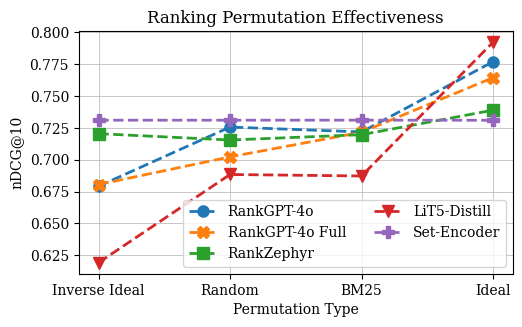

In [14]:
table = corruption_results.pivot_table(index="name", columns=["first_stage"], values=["nDCG@10"]).droplevel(0, axis=1)
table = table.rename(
    {
        "bm25": "BM25",
        "bm25-ideal": "Ideal",
        "bm25-inverse-ideal": "Inverse Ideal",
        "bm25-random": "Random",
    },
    axis=1,
)
table = table.rename(
    {
        "castorini-list-in-t5-300": "LiT5-Distill",
        "set-encoder-large": "Set-Encoder",
        "rankgpt-4o": "RankGPT-4o",
        "rankgpt-4o-full": "RankGPT-4o Full",
        "rankzephyr": "RankZephyr",
    },
    axis=0,
)
models = [
    "RankGPT-4o",
    "RankGPT-4o Full",
    "RankZephyr",
    "LiT5-Distill",
    "Set-Encoder",
]
cases = ["Inverse Ideal", "Random", "BM25", "Ideal"]
table = table.loc[models, cases]


# scale = 2.5
scale = 0.7
fig = plt.figure(figsize=(8 * scale, 4.5 * scale))
# cm = 1 / 2.54
# llncs_width = 12.2 * scale
# height = 5 * scale
# plt.rcParams['figure.constrained_layout.use'] = False
# fig = plt.figure(figsize=(llncs_width * cm, height * cm), layout="constrained")

# grid = plt.GridSpec(2, 4, wspace=-0.5, hspace=-0.5, figure=fig)
# ax = fig.add_subplot(grid[1, :2])
ax = fig.add_subplot(111)

x = list(range(4))
for model_idx, model in enumerate(table.index):
    y = table.loc[model]
    ax.plot(
        x,
        y,
        label=model,
        linewidth=2,
        marker=markers[model_idx],
        markersize=8,
        linestyle="dashed",
    )
ax.set_xticks(x)
ax.set_xticklabels(cases)
ax.set_xlabel("Permutation Type")
ax.set_ylabel("nDCG@10")
ax.set_title("Ranking Permutation Effectiveness")
ax.legend(ncol=2, loc="lower right")
fig.savefig("permutation-effectiveness.pdf", bbox_inches="tight", dpi=500)

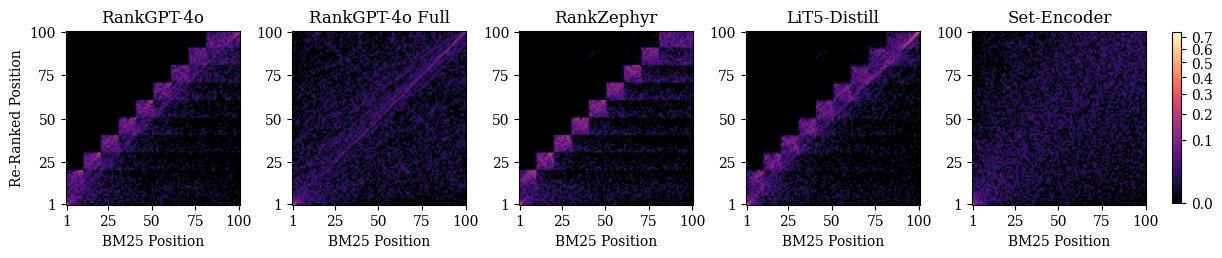

In [15]:
datasets = [
    ("bm25", "msmarco-passage/trec-dl-2019/judged"),
    ("bm25", "msmarco-passage/trec-dl-2020/judged"),
]
first_stage_runs = pd.concat([per_dataset_runs[dataset]["first_stage"] for dataset in datasets])
models = [
    "rankgpt-4o",
    "rankgpt-4o-full",
    "rankzephyr",
    "castorini-list-in-t5-300",
    "set-encoder-large",
]
model_runs = {
    model: pd.concat([per_dataset_runs[dataset][model] for dataset in datasets]) for model in models
}

run_name_map = {
    "rankgpt-4o": "RankGPT-4o",
    "rankgpt-4o-full": "RankGPT-4o Full",
    "rankzephyr": "RankZephyr",
    "castorini-list-in-t5-300": "LiT5-Distill",
    "set-encoder-large": "Set-Encoder",
}

changes = {}

for run_name, runs in model_runs.items():
    run = runs.groupby("query_id").head(100)
    merged = (
        pd.merge(
            runs.drop(["Q0", "score", "run_name"], axis=1),
            first_stage_runs.drop(["Q0", "score", "run_name"], axis=1),
            on=["query_id", "doc_id"],
            how="left",
            suffixes=("_run", "_first_stage"),
        )
        .set_index(["query_id", "doc_id"])
        .astype(int)
    )
    merged = merged.loc[~merged.index.duplicated()]
    merged["rank_first_stage"] = merged.groupby("query_id")["rank_first_stage"].rank().astype(int)
    rank_changes = merged.groupby("rank_run").value_counts().unstack().fillna(0).astype(int).values
    rank_changes = rank_changes / rank_changes.sum(axis=1, keepdims=True)
    changes[run_name] = rank_changes

vmax = max(change.max() for change in changes.values())
from matplotlib.colors import PowerNorm

scale = 0.7
fig, axs = plt.subplots(1, len(model_runs), figsize=(4 * len(model_runs) * scale, 4 * scale))

norm = PowerNorm(gamma=0.5, vmin=0, vmax=vmax)
for idx, (run_name, rank_changes) in enumerate(changes.items()):
    run_name = run_name_map[run_name]
    ax = axs[idx]
    # ax = axs[idx // 3, idx % 3]
    ax.set_title(run_name)
    ax.grid(False)
    ax.set_xlabel("BM25 Position")
    ticks = np.array([1, 25, 50, 75, 100])
    ax.set_xticks(ticks - 1)
    ax.set_yticks(ticks - 1)
    ax.set_xticklabels(ticks)
    ax.set_yticklabels(ticks)
    ax.set_aspect("auto")
    if idx == 0:
        ax.set_ylabel("Re-Ranked Position")
    im = ax.imshow(rank_changes, norm=norm, cmap="magma", origin="lower")


fig.tight_layout()
cbar = fig.colorbar(im, ax=axs, shrink=0.8, pad=0.02)
cbar.ax.set_yticks(np.arange(0, vmax, 0.1));
fig.savefig("rank-changes.pdf", bbox_inches="tight", pad_inches=0, dpi=500)